# Trilinear interpolation

What is the impact of trilinear interpolation on vector magnitude?

The magnetic field vector grid is specified with constant magnitude vectors at the grid points. 
How does evaluating the vector at arbitrary positions via trilinear interpolation 
(https://paulbourke.net/miscellaneous/interpolation/ according to CRPropa comments)
impact the magnitude?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools


# Linestyle iterator
# ls_iter = itertools.cycle(['--', '-', ':', "-."])
ls_list = ['--', '-', ':', "-."]

# Style plot
plt.rcParams.update({'font.size': 20, 
                     'figure.figsize': (12, 10), 
                     'axes.grid.which': 'both',
                     'grid.color': 'lightgrey', 
                     'grid.linestyle': 'dotted', 
                     'axes.grid': True, 
                     'axes.labelsize': 20,
                     'legend.fontsize': 12,
                     'ytick.minor.visible': True}
                   )

def get_vector_direction(amp):
    """Get random unit vector direction for vector of magnitude `amp`/
    
    Parameters
    ----------
    amp : float
        Amplitude/magnitude for vector.
    """
    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1)
    z = np.random.uniform(-1, 1)
    d = np.sqrt(x*x + y*y + z*z)
    
    return amp * x/d, amp * y/d, amp * z/d


def top_ax_to_bot(v):
    """For secondary axis *assuming vector magnitude `vmag` is 1*
    Bottom axis is vector magnitude `v`.
    Top axis is percent *decrease* from vector magnitude.
    """
    vmag = 1.0
    # Top axis value
    return 100*(vmag-v)/vmag 


def bot_ax_to_top(p):
    """For secondary axis *assuming vector magnitude `vmag` is 1*
    Bottom axis is vector magnitude `v`.
    Top axis is percent *decrease* from vector magnitude `p`."""
    vmag = 1.0
    # Bottom axis value
    return vmag*(1-p/100.0)


def evaluate_vector_at_xyz_trilinear_interpolation(x, y, z, 
                                                   cell_length, v_magnitude, v_seed):
    """Evaluate the vector field at the point (x, y, z) where x, y, z are in (0, `cell_length`) Mpc,
    using the trilinear interpolation equation at https://paulbourke.net/miscellaneous/interpolation/
    (CRPropa docs point to this link)
    
    Parameters
    ----------
    x, y, z : floats
        x, y, and z coordinates in Mpc
    cell_length : int or float
        Length of each side of the grid cubic cell in Mpc
    v_magnitude : float
        Fixed vector magnitude at grid points
    v_seed : int
        Seed for random number.
        If None, no seed is specified.
        
    Returns
    -------
    v_xyz_magnitude : float
        Magnitude of interpolated vector
    """
    
    # De-dimensionalize
    x = x / cell_length
    y = y / cell_length
    z = z / cell_length
    cell_length = 1.0
    
    # Coefficient for V_000 term, using notation of https://paulbourke.net/miscellaneous/interpolation/
    c000 = (cell_length - x) * (cell_length - y) * (cell_length - z)
    # V_100 term coefficient
    c100 = x * (cell_length - y) * (cell_length - z)
    # V_010 coefficient
    c010 = (cell_length - x) * y * (cell_length - z)
    # V_001 coefficient
    c001 = (cell_length - x) * (cell_length - y) * z
    # V_101 coefficient
    c101 = x * (cell_length - y) * z
    # V_011 coefficient
    c011 = (cell_length - x) * y * z
    # V_110 coefficient
    c110 = x * y * (cell_length - z)
    # V_111 coefficient
    c111 = x * y * z
    coefficients = np.array([c000, c100, c010, c001, c101, c011, c110, c111])
    
    # Set V000, V100, V010, etc (the vector values at each corner of the cube)
    # with random unit directions but same magnitude
    vectors_at_corners = []
    # Same seed for each function call required for reproducibility; same vectors for each function call 
    np.random.seed(v_seed)
    for i in range(0, 8):
        vectors_at_corners.append(get_vector_direction(v_magnitude))
    vectors = np.array(vectors_at_corners)
    
    # Vector at x, y, z
    v_xyz = np.sum(np.array([vectors[i] * coefficients[i] for i in range(len(vectors))]), 
                   axis=0)
    # Vector magnitude at x, y, z
    v_xyz_magnitude = np.sqrt(np.sum(v_xyz*v_xyz))
    # Vector direction at x, y, z
    v_xyz_unit = v_xyz/v_xyz_magnitude
    
    # Check x, y, z are in (0, `cell_length`)
    if (x > cell_length) | (y > cell_length) | (z > cell_length) | (x < 0) | (y < 0) | (z < 0):
        # Return nan so it is ignored in plotting
        v_xyz_magnitude = np.nan
        # import sys
        # sys.exit(f"Input vector ({x}, {y}, {z}) is outside cell size {cell_length}x{cell_length}x{cell_length}")

    return v_xyz_magnitude
    

def plot_hist_of_interpolated_vector_magnitudes(cell_length, v_magnitude, n, 
                                                v_seed_list=[0, 1], r_seed_list=[10, 20],
                                                plot_legend=True):   
    """Plot histogram of vector magnitudes evaluated using trilinear interpolation at various points (x, y, z) in 
    an individual grid cell. How does the vector magnitude change based on the position r=(x, y, z)?
    Test the impact of position and vector direction.
    
    Parameters
    ----------
    cell_length : int or float
        Length of each side of the grid cubic cell in Mpc
    v_magnitude : float
        Fixed vector magnitude at grid points
    n : int
        Number of random positions (x, y, z) to generate
    v_seed_list : list[int]
        List of seeds for random vector directions.
    r_seed_list : list[int]
        List of seeds for random positions.
        If None, no seed is specified.
    plot_legend : bool
        If True, includes legend.
        If False, legend is not added to plot. This was added because in some cases
        there were many legend labels.    
    """
    
    fig, axh = plt.subplots(1, 1, figsize=(16, 8))
    axh.axvline(v_magnitude, color='grey', label='Vector magnitude $V$ at all grid points', ls='--')
    
    for r_seed in r_seed_list:
        # Note: seed set in `evaluate_vector_at_xyz_trilinear_interpolation` too
        if r_seed is not None:
            np.random.seed(r_seed)
        
        # Get many different positions, each of which are arrays of format (x, y, z)
        xyz_arr = []
        for _ in range(n):
            # Get one random position array 
            xyz_arr.append(np.random.uniform(-1, cell_length+1, size=3))
            
        for k, v_seed in enumerate(v_seed_list):
            # Same linestyle per same vector directions
            ls = ls_list[k]
            # List of interpolated vector magnitudes at many different positions
            v = []    
            for xyz in xyz_arr:
                v.append(evaluate_vector_at_xyz_trilinear_interpolation(xyz[0], xyz[1], xyz[2], 
                                                                        cell_length=cell_length, 
                                                                        v_magnitude=v_magnitude, 
                                                                        v_seed=v_seed)
                        )
            v = np.array(v)
            axh.hist(v, 200, histtype='step', 
                     label=f"$v_i$ ($\\vec{{x}}$ seed={r_seed}, $\\vec{{V}}$ seed={v_seed})",
                     linestyle=ls)
    axh.set_ylabel('Counts', fontsize=18)
    axh.set_xlabel(r'Vector magnitude at $\vec{x}$', fontsize=18)
    axh.set_title(f'Interpolated vector magnitude $v_i$ at {len(xyz_arr):.0e} random coordinates $\\vec{{x}}$\n', 
                  fontweight='bold')
    if plot_legend:
        axh.legend()
    secax = axh.secondary_xaxis('top', functions=(top_ax_to_bot, bot_ax_to_top))
    secax.set_xlabel(f'Percent decrease from $V$')
    plt.show()

# Range of vector magnitudes using one random seed for vector direction and another for position

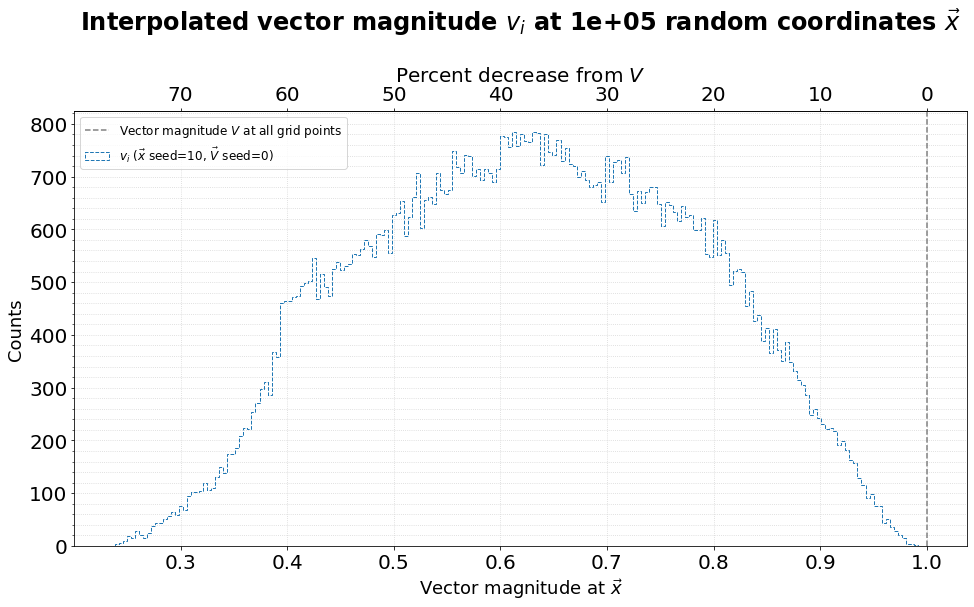

In [2]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(1e5), 
                                            v_seed_list=[0], r_seed_list=[10])

# Range of vector magnitudes not specifying seed for random number generator for position

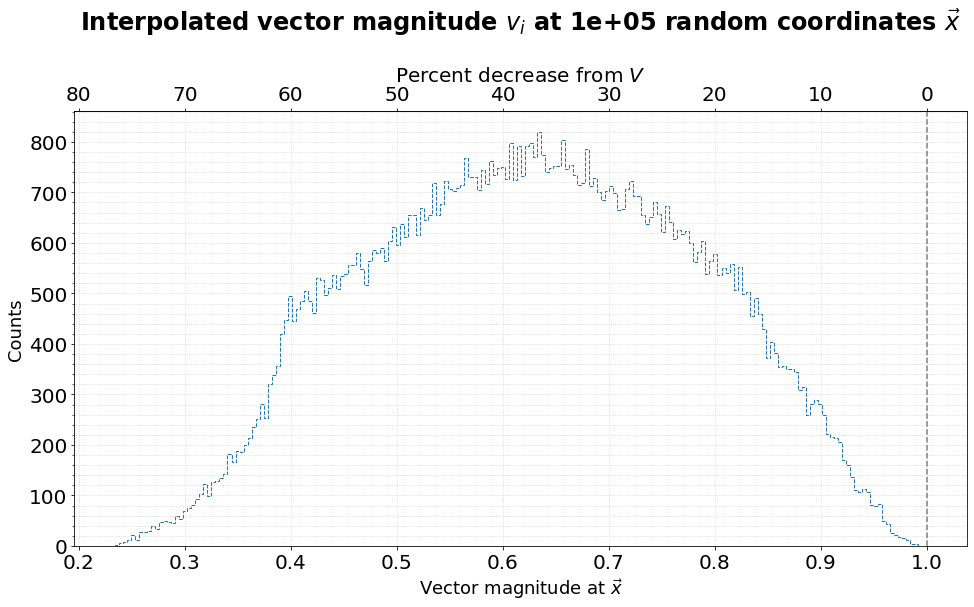

In [3]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(1e5), 
                                            v_seed_list=[0], r_seed_list=[None],
                                            plot_legend=False)

# Range of vector magnitudes specifying same seed for random number generator for both position and vector direction

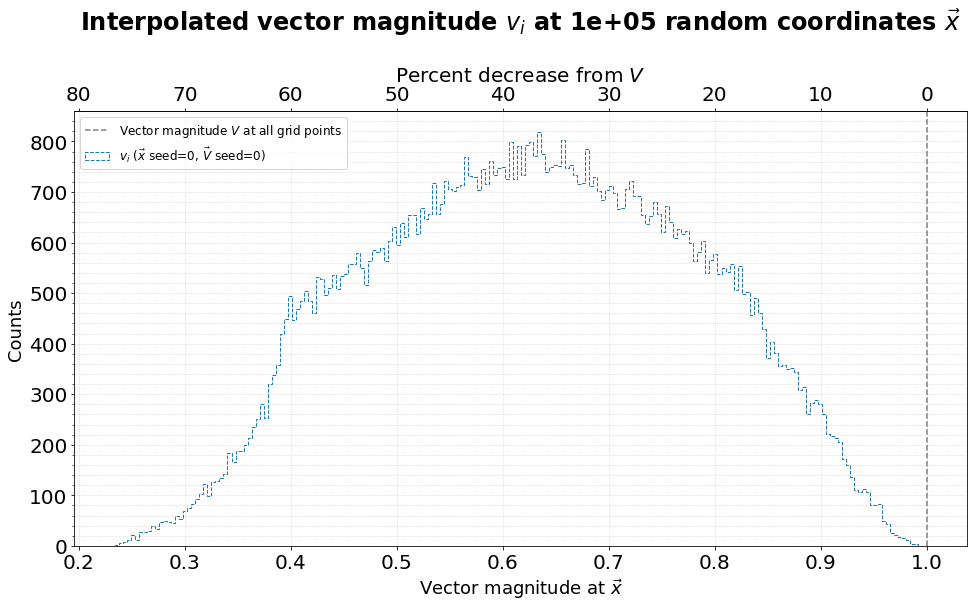

In [4]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(1e5), 
                                            v_seed_list=[0], r_seed_list=[0])

# Range of vector magnitudes using multiple random seeds for vector direction and multiple seeds for position

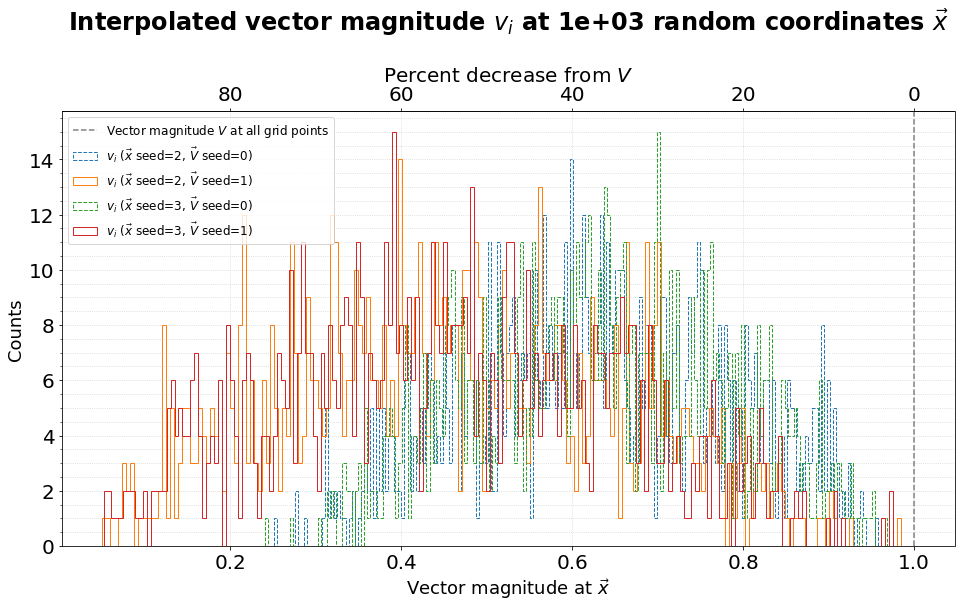

In [5]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(1e3), 
                                            v_seed_list=[0, 1], r_seed_list=[2, 3])

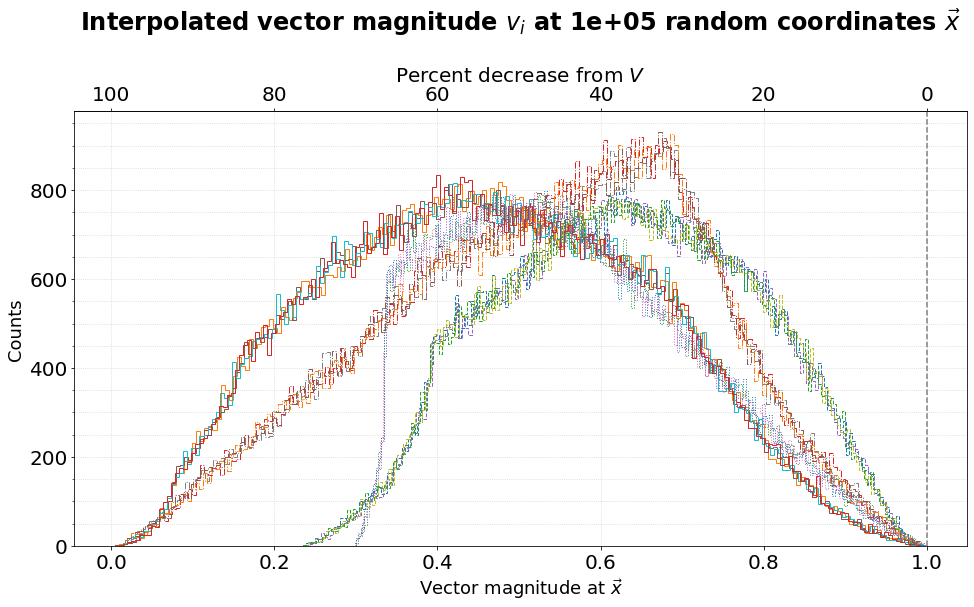

In [6]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(1e5), 
                                            v_seed_list=[0, 1, 2, 3], r_seed_list=[1, 10, 20, 2308],
                                            plot_legend=False)

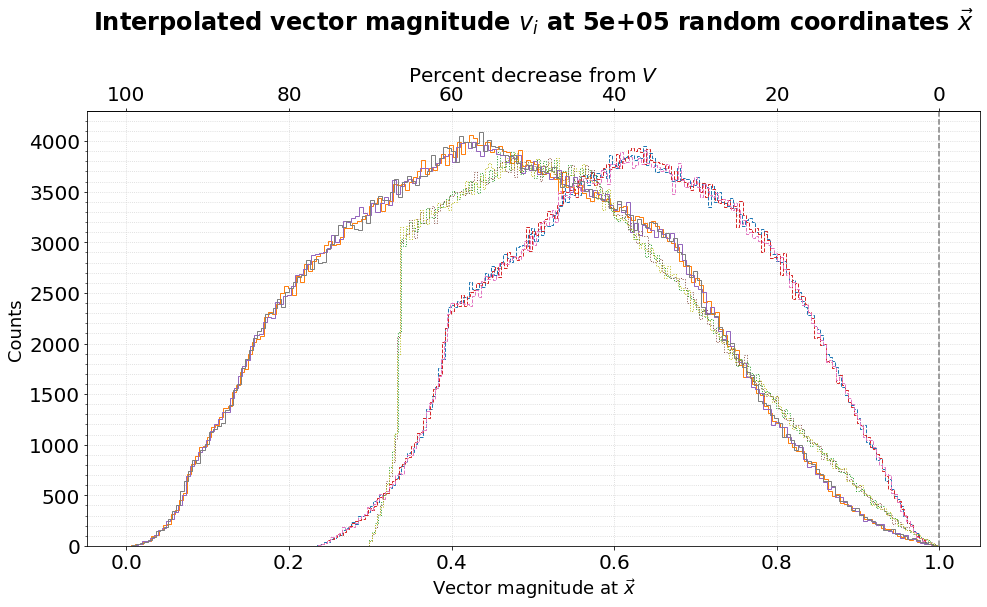

In [8]:
plot_hist_of_interpolated_vector_magnitudes(cell_length=50, v_magnitude=1, n=int(5e5), 
                                            v_seed_list=[0, 1, 2], r_seed_list=[1, 10, 2308],
                                            plot_legend=False)